# Import Libraries

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Load Dataset

In [86]:
import pandas as pd

df = pd.read_csv("train.csv")

print("Train shape:", df.shape)
print("Columns:", list(df.columns)[:10], "...")


Train shape: (1460, 81)
Columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities'] ...


In [87]:
# Top rows
print(df.head(3))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]


In [88]:
# check target distribution
print(df["SalePrice"].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


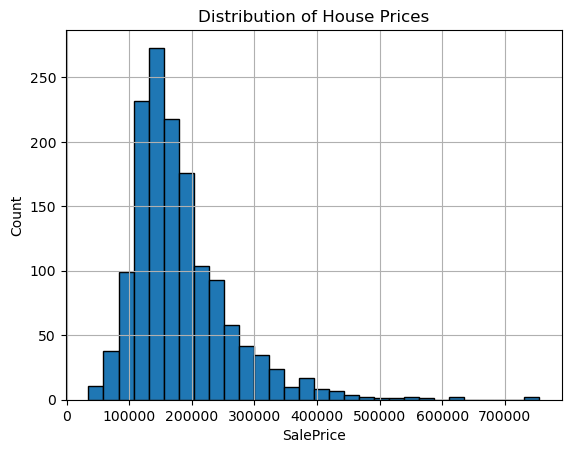

In [89]:
# histogram of target
df["SalePrice"].hist(bins=30, edgecolor="black")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.title("Distribution of House Prices")
plt.show()

# Handling Missing Values

In [113]:
# check missing values (top 20)
missing = df.isna().sum().sort_values(ascending=False)
print("Top missing values:\n", missing.head(20))

Top missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64


In [91]:
df_2 = df.copy()

# fill "None" for categorical features 
none_fill = [
    "PoolQC","MiscFeature","Alley","Fence","FireplaceQu",
    "GarageType","GarageFinish","GarageQual","GarageCond",
    "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
    "MasVnrType"
]
for col in none_fill:
    df_2[col] = df_2[col].fillna("None")

# numerical with median
median_fill = ["LotFrontage","MasVnrArea","GarageYrBlt"]
for col in median_fill:
    df_2[col] = df_2[col].fillna(df_2[col].median())


print("Remaining missing values:", df_2.isna().sum().sum())

Remaining missing values: 0


# Handling outliers

##### GrLivArea -> Gross Living Area (total finished above-grade (above ground) living area of a house.)

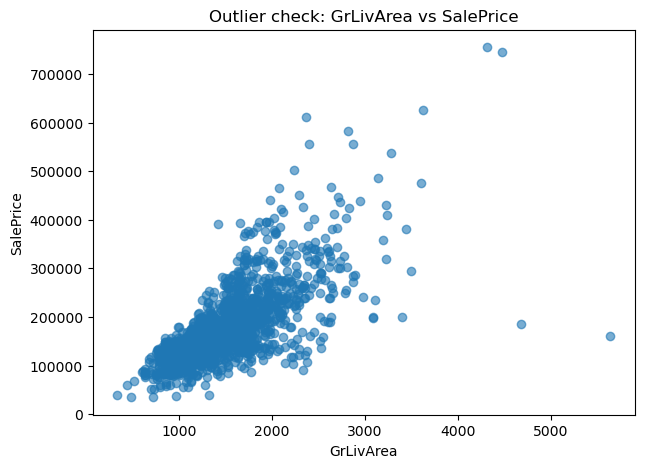

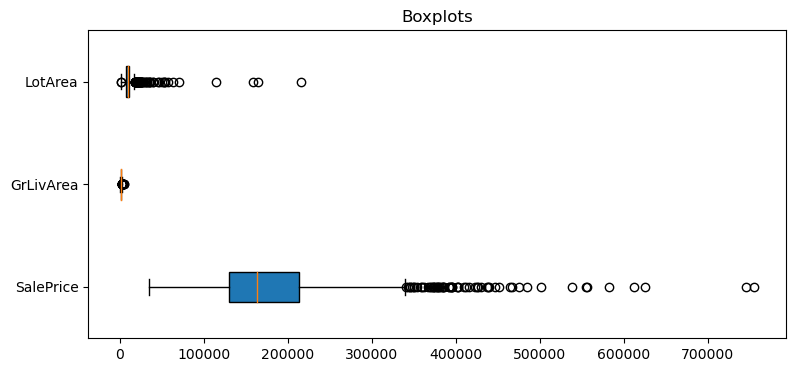

In [92]:
# scatter plot: GrLivArea vs SalePrice
plt.figure(figsize=(7,5))
plt.scatter(df_2["GrLivArea"], df_2["SalePrice"], alpha=0.6)
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("Outlier check: GrLivArea vs SalePrice")
plt.show()

# boxplot: SalePrice, GrLivArea, LotArea
cols = ["SalePrice", "GrLivArea", "LotArea"]
plt.figure(figsize=(9,4))
plt.boxplot([df_2[c].dropna() for c in cols], vert=False, labels=cols, patch_artist=True)
plt.title("Boxplots")
plt.show()

Text(0.05, 0.95, 'Correlation: 0.709')

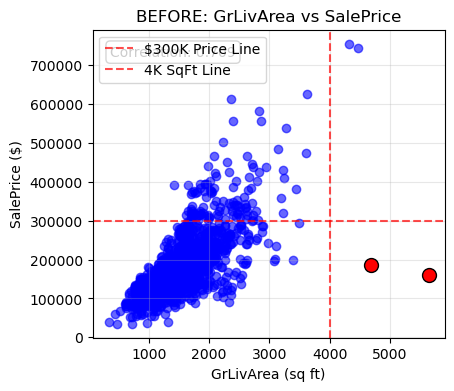

In [93]:
# BEFORE
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(df["GrLivArea"], df["SalePrice"], alpha=0.6, color='blue')
plt.axhline(y=300000, color='red', linestyle='--', alpha=0.7, label='$300K Price Line')
plt.axvline(x=4000, color='red', linestyle='--', alpha=0.7, label='4K SqFt Line')
plt.xlabel("GrLivArea (sq ft)")
plt.ylabel("SalePrice ($)")
plt.title("BEFORE: GrLivArea vs SalePrice")
plt.legend()
plt.grid(alpha=0.3)

# Highlight the problematic points
problem_points = df[(df["GrLivArea"] > 4000) & (df["SalePrice"] < 300000)]
plt.scatter(problem_points["GrLivArea"], problem_points["SalePrice"], 
            color='red', s=100, edgecolor='black', zorder=5, 
            label=f'Illogical Points (n={len(problem_points)})')

# Calculate correlation
corr_before = df["GrLivArea"].corr(df["SalePrice"])
plt.text(0.05, 0.95, f'Correlation: {corr_before:.3f}', 
         transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [94]:
def outlier_report_iqr(df):
    report = []
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df_2[col].quantile(0.25)
        Q3 = df_2[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = df_2[(df_2[col] < lower) | (df_2[col] > upper)]
        if not outliers.empty:
            report.append([col, len(outliers)])
    return pd.DataFrame(report, columns=["Feature","OutlierCount"]).sort_values("OutlierCount", ascending=False)

print("Outliers by IQR rule:")
print(outlier_report_iqr(df_2).head(15))

Outliers by IQR rule:
          Feature  OutlierCount
26  EnclosedPorch           208
8      BsmtFinSF2           167
4     OverallCond           125
28    ScreenPorch           116
1     LotFrontage           106
0      MSSubClass           103
6      MasVnrArea            98
16   BsmtHalfBath            82
25    OpenPorchSF            77
2         LotArea            69
18   KitchenAbvGr            68
31      SalePrice            61
10    TotalBsmtSF            61
30        MiscVal            52
17   BedroomAbvGr            35


In [95]:
# remove houses with very large GrLivArea but low SalePrice
outlier_idx = df_2[(df_2["GrLivArea"] > 4000) & (df_2["SalePrice"] < 300000)].index
print("Indices removed:", outlier_idx.tolist())

df_2 = df_2.drop(outlier_idx).reset_index(drop=True)
print("New shape after selective outlier removal:", df_2.shape)

Indices removed: [523, 1298]
New shape after selective outlier removal: (1458, 81)


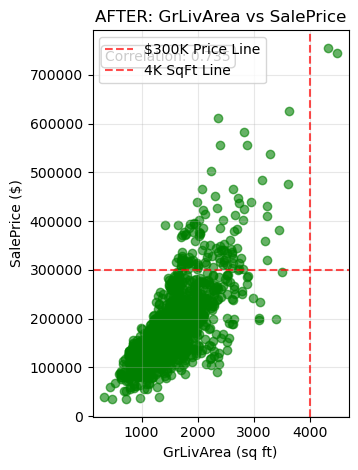

In [96]:
plt.subplot(1, 2, 2)
plt.scatter(df_2["GrLivArea"], df_2["SalePrice"], alpha=0.6, color='green')
plt.axhline(y=300000, color='red', linestyle='--', alpha=0.7, label='$300K Price Line')
plt.axvline(x=4000, color='red', linestyle='--', alpha=0.7, label='4K SqFt Line')
plt.xlabel("GrLivArea (sq ft)")
plt.ylabel("SalePrice ($)")
plt.title("AFTER: GrLivArea vs SalePrice")
plt.legend()
plt.grid(alpha=0.3)

# Show correlation improvement
corr_after = df_2["GrLivArea"].corr(df_2["SalePrice"])
plt.text(0.05, 0.95, f'Correlation: {corr_after:.3f}', 
         transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

 # final data quality assessment

In [97]:
df_3 = df_2.copy() 

In [98]:
print("BASIC INFO")
print("Shape:", df_3.shape)
print("\nData types:\n", df_3.dtypes.value_counts())

print("\n MISSING VALUES")
missing = df_3.isna().sum()
print(missing[missing > 0] if missing.any() else "No missing values ")

print("\n Any NaN left? ->", df_3.isna().any().any())

print("\n DUPLICATES")
print("Duplicate rows:", df_3.duplicated().sum())

print("\n NUMERIC SUMMARY")
print(df_3.describe().T[["mean","std","min","25%","50%","75%","max"]].head(10))

print("\n OUTLIER REPORT (IQR rule)")
def outlier_report_iqr(df):
    report = []
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        if not outliers.empty:
            report.append([col, len(outliers)])
    return pd.DataFrame(report, columns=["Feature","OutlierCount"]).sort_values("OutlierCount", ascending=False)

print(outlier_report_iqr(df_3).head(10))

print("\n CATEGORICAL CHECK")
cat_cols_preview = df_3.select_dtypes(include=["object"]).columns
for col in cat_cols_preview[:10]:
    print(f"{col}: {df_3[col].nunique()} unique values -> {df_3[col].unique()[:5]} ...")

BASIC INFO
Shape: (1458, 81)

Data types:
 object     43
int64      35
float64     3
Name: count, dtype: int64

 MISSING VALUES
No missing values 

 Any NaN left? -> False

 DUPLICATES
Duplicate rows: 0

 NUMERIC SUMMARY
                      mean          std     min      25%     50%       75%  \
Id              730.251715   421.601532     1.0   365.25   730.5   1094.75   
MSSubClass       56.893004    42.329437    20.0    20.00    50.0     70.00   
LotFrontage      69.655693    21.042480    21.0    60.00    69.0     79.00   
LotArea       10459.936900  9859.198156  1300.0  7544.50  9475.0  11600.00   
OverallQual       6.093964     1.376369     1.0     5.00     6.0      7.00   
OverallCond       5.576132     1.113359     1.0     5.00     5.0      6.00   
YearBuilt      1971.218107    30.193754  1872.0  1954.00  1972.5   2000.00   
YearRemodAdd   1984.834019    20.641760  1950.0  1967.00  1994.0   2004.00   
MasVnrArea      102.189986   179.109864     0.0     0.00     0.0    163.75   

In [99]:
# Drop Id, keep SalePrice for later
X_3 = df_3.drop(columns=["SalePrice", "Id"])
y_3 = df_3["SalePrice"]

# numeric & categorical columns
num_cols_3 = X_3.select_dtypes(include=["int64", "float64"]).columns
cat_cols_3 = X_3.select_dtypes(include=["object"]).columns

print("Numeric columns:", len(num_cols_3))
print(num_cols_3[:10])
print("\nCategorical columns:", len(cat_cols_3))
print(cat_cols_3[:10])

Numeric columns: 36
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'],
      dtype='object')

Categorical columns: 43
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1'],
      dtype='object')


In [100]:
# Numeric pipeline
num_transformer_3 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_transformer_3 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combining both
preprocessor_3 = ColumnTransformer(transformers=[
    ("num", num_transformer_3, num_cols_3),
    ("cat", cat_transformer_3, cat_cols_3)
])

# Applying preprocessing
X_3_prepared = preprocessor_3.fit_transform(X_3)

print("Original shape (X_3):", X_3.shape)
print("Transformed shape (X_3_prepared):", X_3_prepared.shape)

# NaN checking
X_3_dense = X_3_prepared.toarray() if hasattr(X_3_prepared, "toarray") else X_3_prepared
print("Any NaN after preprocessing? ->", np.isnan(X_3_dense).any())

Original shape (X_3): (1458, 79)
Transformed shape (X_3_prepared): (1458, 301)
Any NaN after preprocessing? -> False


In [101]:
# Getting new feature names
feature_names_3 = preprocessor_3.get_feature_names_out()

# Building processed DataFrame
df_3 = pd.DataFrame(X_3_dense, columns=feature_names_3, index=X_3.index)

# Addding SalePrice back (keep name!)
df_3["SalePrice"] = y_3.values

print("Final df_3 shape:", df_3.shape)
df_3.head(3)

Final df_3 shape: (1458, 302)


,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,...,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_WD,cat__SaleCondition_Abnorml,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial,SalePrice
0,0.073426,-0.221328,-0.203934,0.658506,-0.517649,1.052959,0.880362,0.523937,0.617283,-0.288867,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500
1,-0.871868,0.491760,-0.087252,-0.068293,2.177825,0.158428,-0.428115,-0.570739,1.245719,-0.288867,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500
2,0.073426,-0.078710,0.080162,0.658506,-0.517649,0.986698,0.831900,0.334044,0.108989,-0.288867,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500


# correlation matrix (numeric features only)

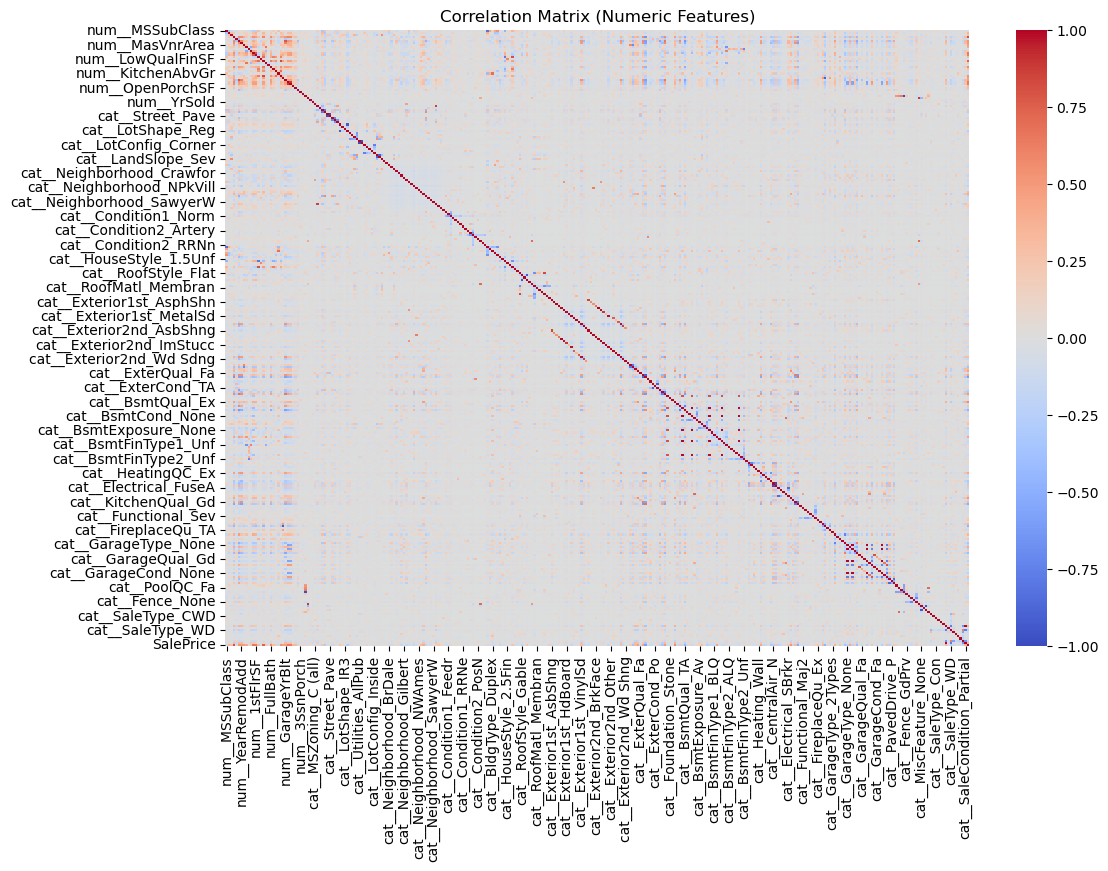

In [102]:
# compute correlation
corr_matrix = df_3.corr(numeric_only=True)

# heatmap 
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [103]:
# correlations with SalePrice
target_corr = corr_matrix["SalePrice"].sort_values(ascending=False)

print("Top 10 features correlated with SalePrice:\n", target_corr.head(10))
print("\nLowest 10 features:\n", target_corr.tail(10))

Top 10 features correlated with SalePrice:
 SalePrice            1.000000
num__OverallQual     0.795774
num__GrLivArea       0.734968
num__TotalBsmtSF     0.651153
num__GarageCars      0.641047
num__1stFlrSF        0.631530
num__GarageArea      0.629217
num__FullBath        0.562165
cat__BsmtQual_Ex     0.557860
num__TotRmsAbvGrd    0.537769
Name: SalePrice, dtype: float64

Lowest 10 features:
 cat__MSZoning_RM         -0.288169
cat__HeatingQC_TA        -0.312869
cat__Foundation_CBlock   -0.343582
cat__GarageType_Detchd   -0.354326
cat__MasVnrType_None     -0.368020
cat__GarageFinish_Unf    -0.410942
cat__BsmtQual_TA         -0.452785
cat__FireplaceQu_None    -0.472350
cat__KitchenQual_TA      -0.519821
cat__ExterQual_TA        -0.589909
Name: SalePrice, dtype: float64


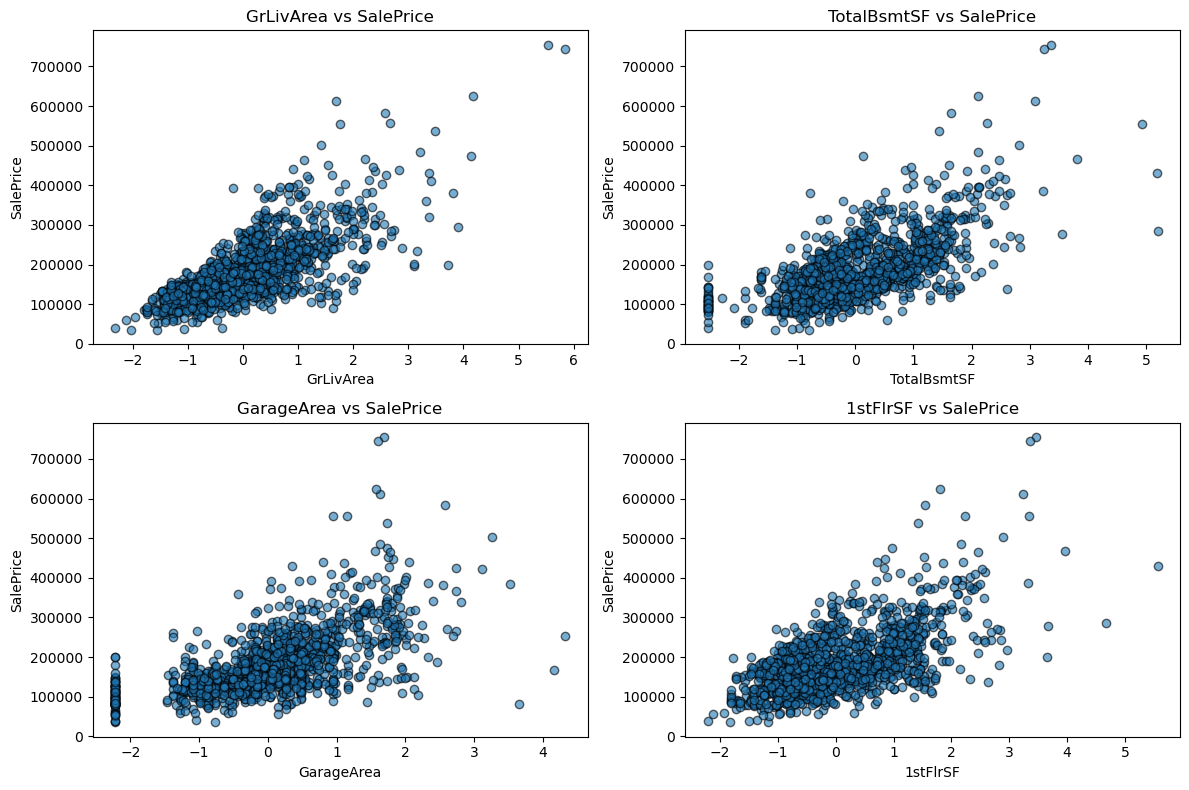

In [104]:
top_features = ["num__GrLivArea", "num__TotalBsmtSF", "num__GarageArea", "num__1stFlrSF"]

plt.figure(figsize=(12,8))
for i, col in enumerate(top_features, 1):
    plt.subplot(2,2,i)
    plt.scatter(df_3[col], df_3["SalePrice"], alpha=0.6, edgecolors="k")
    plt.xlabel(col.replace("num__", ""))  
    plt.ylabel("SalePrice")
    plt.title(f"{col.replace('num__','')} vs SalePrice")
plt.tight_layout()
plt.show()

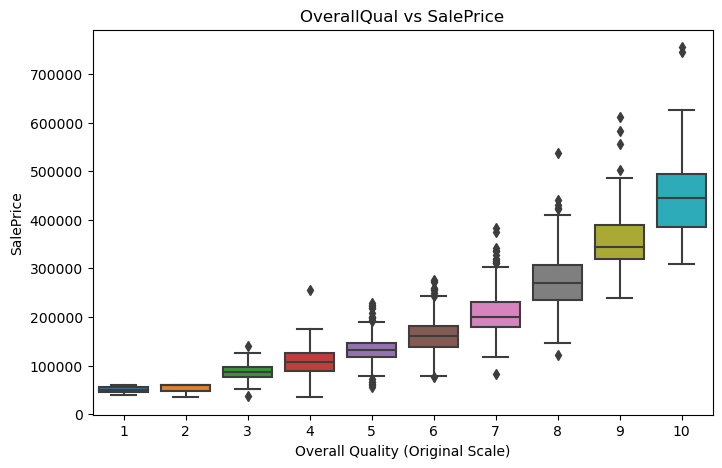

In [117]:
plt.figure(figsize=(8,5))
sns.boxplot(x=X_3["OverallQual"], y=y_3)
plt.title("OverallQual vs SalePrice")
plt.xlabel("Overall Quality (Original Scale)")
plt.show()

C:\Users\fazlu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


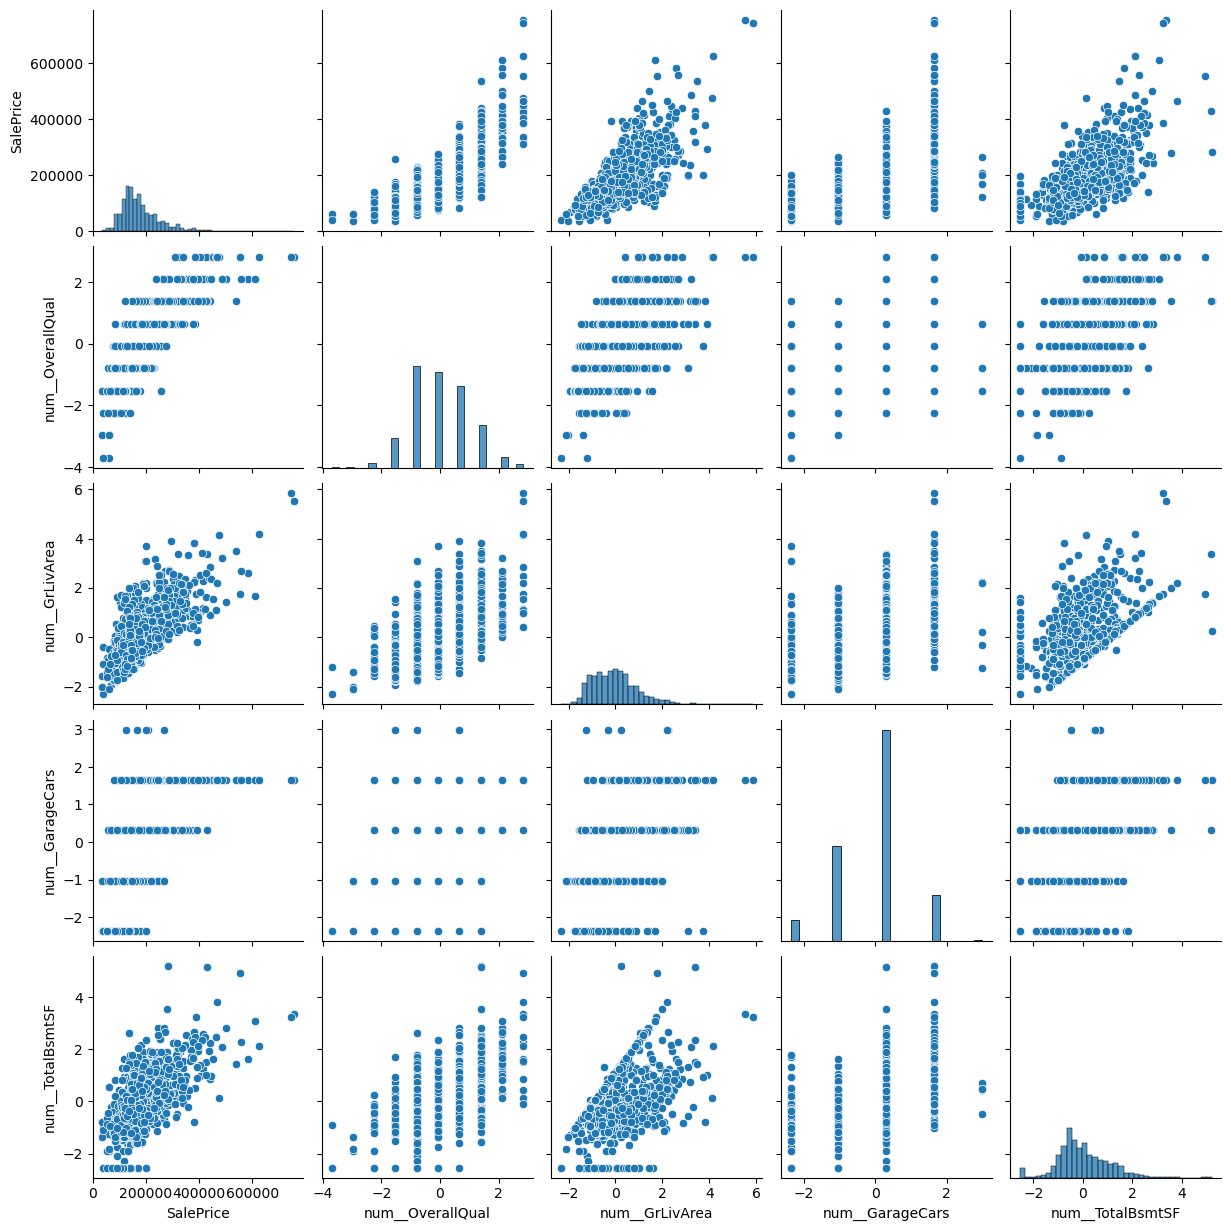

In [106]:
sns.pairplot(df_3[["SalePrice", "num__OverallQual", "num__GrLivArea", "num__GarageCars", "num__TotalBsmtSF"]])
plt.show()


# correlation heatmap (top 10 with SalePrice)

Top correlated features: ['SalePrice', 'num__OverallQual', 'num__GrLivArea', 'num__TotalBsmtSF', 'num__GarageCars', 'num__1stFlrSF', 'num__GarageArea', 'cat__ExterQual_TA', 'num__FullBath', 'cat__BsmtQual_Ex', 'num__TotRmsAbvGrd']


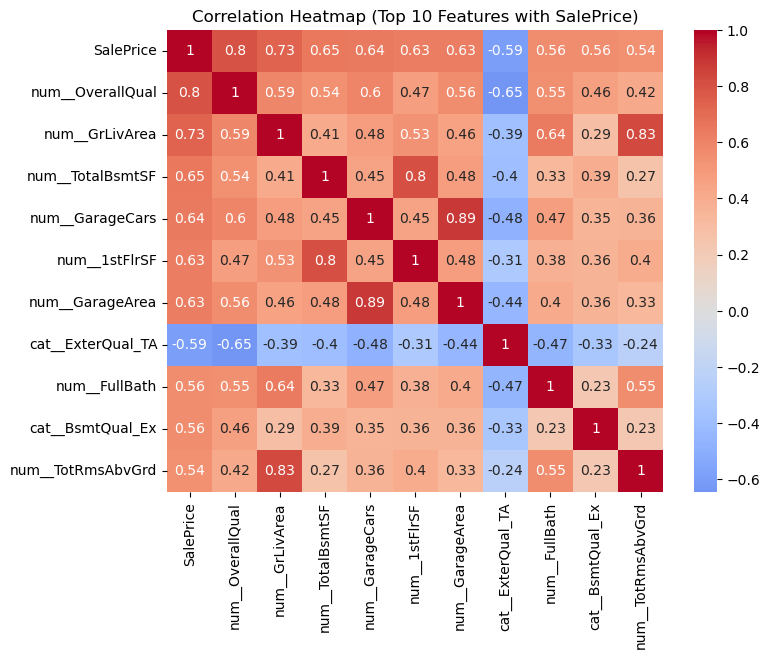

In [107]:
# compute correlations
corr_matrix = df_3.corr(numeric_only=True)

# pick top 10 correlated with SalePrice
top_features = corr_matrix["SalePrice"].abs().sort_values(ascending=False).head(11).index
print("Top correlated features:", list(top_features))

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_3[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Top 10 Features with SalePrice)")
plt.show()

In [108]:
# ----- Size Features -----
df_3["TotalSF"] = (
    df_3["num__1stFlrSF"].fillna(0) +
    df_3["num__2ndFlrSF"].fillna(0) +
    df_3["num__BsmtFinSF1"].fillna(0) +
    df_3["num__BsmtFinSF2"].fillna(0) +
    df_3["num__BsmtUnfSF"].fillna(0)
)

# Bathrooms (use what exists; fill NaNs; 0.5 weighting for half baths)
total_baths = 0
if "num__HalfBath" in df_3:       total_baths = total_baths + df_3["num__HalfBath"].fillna(0) * 0.5
if "num__BsmtHalfBath" in df_3:   total_baths = total_baths + df_3["num__BsmtHalfBath"].fillna(0) * 0.5
if "num__BsmtFullBath" in df_3:   total_baths = total_baths + df_3["num__BsmtFullBath"].fillna(0)
if "num__FullBath" in df_3:       total_baths = total_baths + df_3["num__FullBath"].fillna(0)
df_3["TotalBaths"] = total_baths

# ----- Age Features (clip to >= 0) -----
yr_sold = df_3["num__YrSold"].fillna(df_3["num__YrSold"].median())

df_3["HouseAge"] = (yr_sold - df_3["num__YearBuilt"].fillna(df_3["num__YearBuilt"].median())).clip(lower=0)
df_3["RemodAge"] = (yr_sold - df_3["num__YearRemodAdd"].fillna(df_3["num__YearRemodAdd"].median())).clip(lower=0)
if "num__GarageYrBlt" in df_3:
    df_3["GarageAge"] = (yr_sold - df_3["num__GarageYrBlt"].fillna(df_3["num__GarageYrBlt"].median())).clip(lower=0)

# ----- Quality Interactions (fill NaNs to avoid propagating) -----
df_3["Qual_LivArea"] = (
    df_3["num__OverallQual"].fillna(df_3["num__OverallQual"].median()) *
    df_3["num__GrLivArea"].fillna(0)
)
df_3["Qual_TotalSF"] = (
    df_3["num__OverallQual"].fillna(df_3["num__OverallQual"].median()) *
    df_3["TotalSF"]
)

# ----- Log Transforms (safe: fill NaNs & remove ±inf) -----
df_3["SalePrice_log"] = np.log1p(df_3["SalePrice"].fillna(df_3["SalePrice"].median()))

if "num__LotArea" in df_3:
    df_3["LotArea_log"] = np.log1p(df_3["num__LotArea"].fillna(0))

df_3["GrLivArea_log"] = np.log1p(df_3["num__GrLivArea"].fillna(0))

# Final clean-up for any accidental inf/NaN created above
cols_check = ["TotalSF","TotalBaths","HouseAge","RemodAge","Qual_LivArea",
              "Qual_TotalSF","SalePrice_log","GrLivArea_log"]
if "LotArea_log" in df_3: cols_check.append("LotArea_log")
if "GarageAge" in df_3:   cols_check.append("GarageAge")

df_3[cols_check] = (
    df_3[cols_check]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(0)
)

print(" Feature engineering updated safely. New shape:", df_3.shape)
print("New/updated features:", cols_check)

 Feature engineering updated safely. New shape: (1458, 312)
New/updated features: ['TotalSF', 'TotalBaths', 'HouseAge', 'RemodAge', 'Qual_LivArea', 'Qual_TotalSF', 'SalePrice_log', 'GrLivArea_log', 'LotArea_log', 'GarageAge']


C:\Users\fazlu\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Feature Engineering Summary
Newly Created Features

Total interior square footage
Combined area of all floors + basement.

Weighted bathroom count
Full bath = 1, Half bath = 0.5.

House age at sale (years)
Sale year − Year built.

Years since last major renovation
Sale year − Year remodeled.

Garage age (if garage exists)
Sale year − Garage construction year.

Quality premium for living area
Higher quality + larger living space = higher value estimate.

Quality premium for total square footage
Higher total area + overall quality.

Log-transformed sale price
Stabilizes skewed price distribution.

Log-transformed living area
Reduces skew of large homes.

Log-transformed lot area
Handles very large lot size outliers.

Original dataset: 81 features
After preprocessing: 302 features
After your engineering: 312 features gie it in markdwon

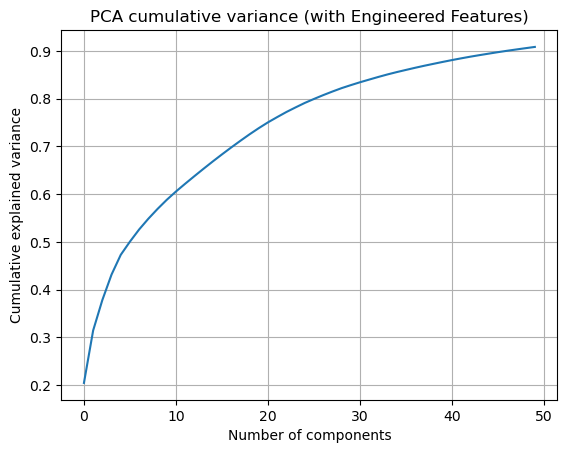

Variance with first 10 components: [0.20465735 0.31450606 0.37828552 0.43162528 0.47291935 0.50058885
 0.52605643 0.54849111 0.5690305  0.58808599]

=== ENGINEERED FEATURE RANKINGS ===
TotalSF              → Rank:   5/310 | Score: 0.4590
TotalBaths           → Rank:   6/310 | Score: 0.4517
HouseAge             → Rank:  12/310 | Score: 0.3311
RemodAge             → Rank:  13/310 | Score: 0.3282
Qual_LivArea         → Rank:  10/310 | Score: 0.3433
Qual_TotalSF         → Rank:   1/310 | Score: 0.8110
GrLivArea_log        → Rank:  44/310 | Score: 0.1488
LotArea_log          → Rank:  42/310 | Score: 0.1576
GarageAge            → Rank:  14/310 | Score: 0.3145

 TOP 30 FEATURES (out of 310)
Selected features: ['Qual_TotalSF', 'num__YrSold', 'num__BsmtFinSF2', 'num__BsmtUnfSF', 'TotalSF', 'TotalBaths', 'num__KitchenAbvGr', 'num__2ndFlrSF', 'num__MasVnrArea', 'Qual_LivArea', 'num__BsmtFullBath', 'HouseAge', 'RemodAge', 'GarageAge', 'num__OverallCond', 'num__BsmtFinSF1', 'num__ScreenPorch', 'num

In [122]:
# Separate features & target (using log target for normality)
X = df_3.drop(columns=["SalePrice", "SalePrice_log"])  
y = df_3["SalePrice_log"]  

# Apply PCA
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

# Explained variance plot
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumvar)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA cumulative variance (with Engineered Features)")
plt.grid(True)
plt.show()

print("Variance with first 10 components:", cumvar[:10])

# Loadings (how much each feature contributes to each component)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns  # Includes engineered features
)

# Aggregate feature importance = max absolute loading across top 10 PCs
feature_importance = loadings.iloc[:, :10].abs().max(axis=1).sort_values(ascending=False)

# Check engineered feature rankings
print("\n=== ENGINEERED FEATURE RANKINGS ===")
engineered_features = ["TotalSF", "TotalBaths", "HouseAge", "RemodAge", 
                       "Qual_LivArea", "Qual_TotalSF", "GrLivArea_log", 
                       "LotArea_log"]
if "GarageAge" in X.columns:
    engineered_features.append("GarageAge")

for feat in engineered_features:
    if feat in feature_importance.index:
        rank = list(feature_importance.index).index(feat) + 1  # 1-based ranking
        importance_score = feature_importance[feat]
        print(f"{feat:20} → Rank: {rank:3d}/{len(X.columns)} | Score: {importance_score:.4f}")
    else:
        print(f"{feat:20} → NOT FOUND in feature importance")

# Pick top 30 features 
top_features = feature_importance.head(30).index.tolist()
print(f"\n TOP 30 FEATURES (out of {len(X.columns)})")
print("Selected features:", top_features)

# Count how many engineered features made top 30
engineered_in_top = [f for f in top_features if f in engineered_features]
print(f"\nEngineered features in top 30: {len(engineered_in_top)}/{len(engineered_features)}")
print("They are:", engineered_in_top)

Top Performers (PCA Ranking):
Qual_TotalSF -most important feature overall

TotalSF - no.5 most important

TotalBaths - no.6 most important

Qual_LivArea - no.10 most important

-------
7 out of 10 engineered features made the top 30 most important features list!


Top 15 positively correlated features:
 SalePrice              1.000000
SalePrice_log          0.948396
num__OverallQual       0.795774
TotalSF                0.771251
num__GrLivArea         0.734968
num__TotalBsmtSF       0.651153
num__GarageCars        0.641047
num__1stFlrSF          0.631530
num__GarageArea        0.629217
TotalBaths             0.615700
num__FullBath          0.562165
cat__BsmtQual_Ex       0.557860
num__TotRmsAbvGrd      0.537769
num__YearBuilt         0.523608
cat__KitchenQual_Ex    0.509425
Name: SalePrice, dtype: float64 

Lowest 15 negatively correlated features:
 cat__BsmtExposure_No     -0.264150
cat__LotShape_Reg        -0.268191
cat__MSZoning_RM         -0.288169
GarageAge                -0.290129
cat__HeatingQC_TA        -0.312869
HouseAge                 -0.332194
cat__Foundation_CBlock   -0.343582
RemodAge                 -0.350990
cat__GarageType_Detchd   -0.354326
cat__MasVnrType_None     -0.368020
cat__GarageFinish_Unf    -0.410942
cat__BsmtQual_TA  

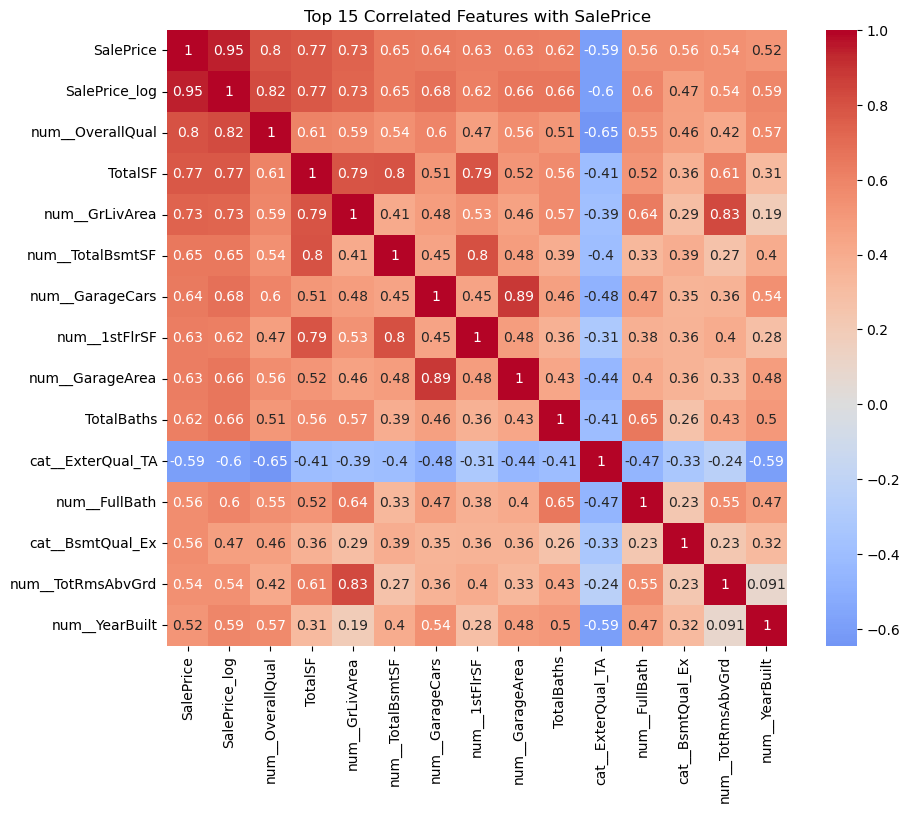

In [110]:
# 1) Correlation of all numeric features with SalePrice
corr = df_3.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)

print("Top 15 positively correlated features:\n", corr.head(15), "\n")
print("Lowest 15 negatively correlated features:\n", corr.tail(15))

# 2) Focus only on engineered features
engineered = ["TotalSF", "TotalBaths", "HouseAge", "RemodAge",
              "GarageAge", "Qual_LivArea", "Qual_TotalSF",
              "LotArea_log", "GrLivArea_log"]

print("\nCorrelation of engineered features with SalePrice:\n")
print(corr.loc[corr.index.intersection(engineered)])

# 3) Heatmap of top correlations 
top_corr_features = corr.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10,8))
sns.heatmap(df_3[top_corr_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Top 15 Correlated Features with SalePrice")
plt.show()

In [120]:
X_top = df_3[top_features]  # 30 features
y = df_3["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X_top, y, test_size=0.2, random_state=42)

# === BASELINE: Predict mean price ===
baseline_pred = np.full_like(y_val, y_train.mean())  # Predict training mean for validation
baseline_rmse = mean_squared_error(y_val, baseline_pred, squared=False)
baseline_r2 = r2_score(y_val, baseline_pred)

# === MODEL 1: Linear Regression ===
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_val)
linreg_rmse = mean_squared_error(y_val, y_pred_linreg, squared=False)
linreg_r2 = r2_score(y_val, y_pred_linreg)

# === MODEL 2: Ridge ===
ridge = Ridge(alpha=10, random_state=42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)
ridge_rmse = mean_squared_error(y_val, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_val, y_pred_ridge)

# === MODEL 3: Random Forest ===
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rf_rmse = mean_squared_error(y_val, y_pred_rf, squared=False)
rf_r2 = r2_score(y_val, y_pred_rf)

# === RESULTS ===
results = pd.DataFrame({
    "Model": ["Baseline (Mean)", "Linear (30 PCA)", "Ridge (30 PCA)", "Random Forest (30 PCA)"],
    "RMSE": [baseline_rmse, linreg_rmse, ridge_rmse, rf_rmse],
    "R²": [baseline_r2, linreg_r2, ridge_r2, rf_r2]
})

print("MODEL COMPARISON (30 PCA Features)")
print(results)
print(f"\nBaseline Prediction: ${y_train.mean():.0f} (mean training price)")
print(f"Feature set: {X_train.shape[1]} features")
print(f"Features: {list(X_train.columns)}")

# Calculate improvement percentages
print("\nIMPROVEMENT OVER BASELINE")
for model_name, rmse in [("Linear", linreg_rmse), ("Ridge", ridge_rmse), ("Random Forest", rf_rmse)]:
    improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100
    print(f"{model_name}: {improvement:.1f}% better than baseline")

MODEL COMPARISON (30 PCA Features)
                    Model          RMSE        R²
0         Baseline (Mean)  74323.791401 -0.000054
1         Linear (30 PCA)  28668.435601  0.851209
2          Ridge (30 PCA)  28597.850914  0.851941
3  Random Forest (30 PCA)  24681.903717  0.889713

Baseline Prediction: $180824 (mean training price)
Feature set: 30 features
Features: ['Qual_TotalSF', 'num__YrSold', 'num__BsmtFinSF2', 'num__BsmtUnfSF', 'TotalSF', 'TotalBaths', 'num__KitchenAbvGr', 'num__2ndFlrSF', 'num__MasVnrArea', 'Qual_LivArea', 'num__BsmtFullBath', 'HouseAge', 'RemodAge', 'GarageAge', 'num__OverallCond', 'num__BsmtFinSF1', 'num__ScreenPorch', 'num__LotFrontage', 'num__MSSubClass', 'num__YearBuilt', 'num__GarageYrBlt', 'num__BedroomAbvGr', 'num__TotalBsmtSF', 'num__Fireplaces', 'num__YearRemodAdd', 'num__HalfBath', 'num__1stFlrSF', 'num__TotRmsAbvGrd', 'num__EnclosedPorch', 'num__GrLivArea']

IMPROVEMENT OVER BASELINE
Linear: 61.4% better than baseline
Ridge: 61.5% better than base

In [128]:
# FINAL MODEL TRAINING & PREDICTION

# Combine training and validation data for final training
X_all = pd.concat([X_train, X_val])
y_all = pd.concat([y_train, y_val])

print(f"Training final model on all {len(X_all)} samples with {X_all.shape[1]} features.")

# Select the best performing model based on validation results
# Random Forest showed the best RMSE and R²
final_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
final_model.fit(X_all, y_all)

# Demonstrate predictions on the validation set (as a proxy for new data)
print("\n PREDICTION DEMONSTRATION ")
print("Predicting prices for first 10 houses in validation set:\n")

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Price': y_val.values[:10],
    'Predicted Price': final_model.predict(X_val.iloc[:10])
})

# Format as dollars
comparison_df['Actual Price'] = comparison_df['Actual Price'].apply(lambda x: f"${x:,.0f}")
comparison_df['Predicted Price'] = comparison_df['Predicted Price'].apply(lambda x: f"${x:,.0f}")

print(comparison_df.to_string(index=False))

# Calculate error metrics for demonstration
val_predictions = final_model.predict(X_val)
final_rmse = mean_squared_error(y_val, val_predictions, squared=False)
final_r2 = r2_score(y_val, val_predictions)

print(f"\nFinal model performance on validation set:")
print(f"RMSE: ${final_rmse:,.0f}")
print(f"R²: {final_r2:.3f}")

# Show feature importance if using tree-based model
if hasattr(final_model, 'feature_importances_'):
    print("\n TOP 10 MOST IMPORTANT FEATURES ")
    feature_importance = pd.DataFrame({
        'Feature': X_all.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    print(feature_importance.to_string(index=False))

Training final model on all 1458 samples with 30 features.

 PREDICTION DEMONSTRATION 
Predicting prices for first 10 houses in validation set:

Actual Price Predicted Price
    $190,000        $201,723
    $100,000         $98,181
    $115,000        $113,491
    $159,000        $159,016
    $315,500        $308,731
    $137,500        $142,122
    $311,500        $267,554
    $310,000        $312,475
    $281,000        $274,818
    $135,500        $135,284

Final model performance on validation set:
RMSE: $9,190
R²: 0.985

 TOP 10 MOST IMPORTANT FEATURES 
          Feature  Importance
          TotalSF    0.456998
     Qual_TotalSF    0.277786
   num__YearBuilt    0.079921
     Qual_LivArea    0.039918
  num__BsmtFinSF1    0.019277
   num__GrLivArea    0.017262
       TotalBaths    0.011630
num__YearRemodAdd    0.010150
 num__LotFrontage    0.009643
    num__2ndFlrSF    0.009333
